[2.36464646]
Density of nebular at 0.1 AU is:  2.1283729573951933e-06 and the density at Q = 1 at 0.1 AU is 0.0001890993908499939
Density of nebular at 1.5 AU is:  2.609549366104725e-09 and the density at Q = 1 at 1 AU is 1.8909939084999386e-07
The density ratio of nebular at 1AU is 13.8744511777071 with Q =  13.8744511777071


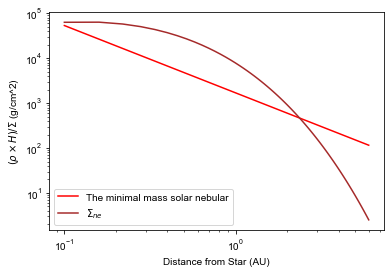

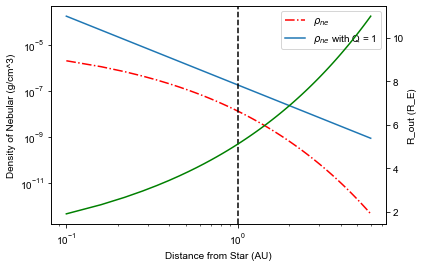

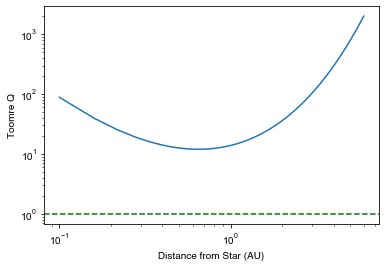

In [4]:
#%reset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure
import matplotlib.transforms as transforms
from scipy import integrate
import scipy

SMALL_SIZE = 10
matplotlib.rc('font',size = SMALL_SIZE, family = 'Arial')
matplotlib.rc('axes',titlesize = SMALL_SIZE)


#define distance to sun/star
a = np.linspace(0.1, 6.0, 100) #[AU]

hfont = {'fontname':'Helvetica'}



#define constants 
mu = 2.34
m_p = 1.67*10**(-24) #[g]
k_B = 1.38*10**(-16)#[erg/K]
G = 6.67408 * 10**(-8) #[dyne cm^2/g^2]
M_mars = 0.64171*10**(27) #[g]
M_sun = 1.989*10**(33) #[g]
M_earth = 5.98*10**27 #[g]
R_E = 6.378*10**8 #[cm]
autocm = 1.496*10**(13)

#define parameters of Mars
P_bot = 10**6 #[Ba] 
R_bot = 3.38*10**8 #[cm] https://www.sciencedirect.com/topics/physics-and-astronomy/planetary-cores

T_0 = 1000

#define temperature
def T_disk(a):
    return T_0*(a/0.1)**(-3/7) #[K]

def Cs_disk(a):
    return np.sqrt(k_B*T_disk(a)/mu/m_p) #CHECK UNITS [cm/s]

def rho_ne(a, M):

    #compute the R_out based on Boundy/Hill Radisu
    R_H = a*(M/3/M_sun)**(1/3)*autocm #cm
    R_B = G*M/Cs_disk(a)**2 #cm
    
    if type(a) is float:
        R_out = [0]
        R_out = min(R_H,R_B)
        R_out_E = R_out/R_E
    else:
        R_out = [0]*len(R_H)
        for i in range(len(R_H)):
            R_out[i] = min(R_B[i],R_H[i])
        #Bondi Radius always smaller
        R_out_E = [i/R_E for i in R_out]
    
    A = G*M/Cs_disk(a)**2 #CHECK UNITS [cm]

    exp = np.exp(-A/R_out + A/R_bot)
    rho_bot = P_bot/Cs_disk(a)**2 #[g/cm^3]
    
    return rho_bot/exp, R_out_E

def Q(a,rho_ne):
    K = np.sqrt(G*M_sun/(a*autocm)**3) #[1/s]
    H = Cs_disk(a)/K #[cm]
    Q = K*Cs_disk(a)/G/H/rho_ne/np.pi
    
    rho_Q1 = K*Cs_disk(a)/G/H/np.pi
    return Q, rho_Q1

def rho_sig(a,rho_ne):
    K = np.sqrt(G*M_sun/(a*autocm)**3) #[1/s]
    H = Cs_disk(a)/K #[cm]
    sig_ne = rho_ne*H
    mini_sig = 1.7*10**3*a**(-3/2)
    return sig_ne/mini_sig, sig_ne
    

Cs_disk_sol = Cs_disk(a)

rho_ne_sol, R_out = rho_ne(a, M_mars)
Q_sol, Q_1 = Q(a , rho_ne_sol)

rs = rho_sig(a, rho_ne_sol)[0]
sig_ne = rho_sig(a, rho_ne_sol)[1]
mini_sig = 1.7*10**3*a**(-3/2)

idx = np.argwhere(np.diff(np.sign(sig_ne - mini_sig))).flatten()
print(a[idx])

tt = a[idx]

de = 0.1

print('Density of nebular at',de,'AU is: ',rho_ne(de, M_mars)[0],'and the density at Q = 1 at 0.1 AU is',Q(0.1,rho_ne(0.1, M_mars)[0])[1])
print('Density of nebular at 1.5 AU is: ',rho_ne(1.5, M_mars)[0],'and the density at Q = 1 at 1 AU is',Q(1.,rho_ne(1., M_mars)[0])[1])

print('The density ratio of nebular at 1AU is', Q(1.,rho_ne(0.1, M_mars)[0])[1]/rho_ne(1., M_mars)[0],'with Q = ',Q(1.,rho_ne(1.0, M_mars)[0])[0] )

# try seeing it for the Earth
ne_earth, R_out_earth = rho_ne(a, M_earth)

# figures 


#plt.plot(a, rs,'green',linestyle = '--',label = r'$\Sigma_{ne}/\Sigma_{min}$',linewidth = 2.2)
plt.plot(a, 1.7*10**3*a**(-3/2), 'red', label = 'The minimal mass solar nebular')
plt.plot(a, sig_ne,'brown',label = r'$\Sigma_{ne}$')
#plt.axvline(x = a[idx],color = 'black')

#plt.text(1.1*a[idx], 8, f'{tt} AU')
plt.xlabel("Distance from Star (AU)")
plt.ylabel(r'$(\rho \times H)/\Sigma$ (g/cm^2)')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.savefig("rho_sig_M150.png",dpi=300, bbox_inches='tight')
plt.show()

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(a, rho_ne_sol,'-.', color = 'red',label = r'$\rho_{ne}$')
ax1.plot(a, Q_1, label = r'$\rho_{ne}$ with Q = 1')
ax2.plot(a, R_out, color = 'green')
ax1.axvline(x = 1,linestyle = '--',color = 'black')
ax1.set_xlabel("Distance from Star (AU)")
ax1.set_ylabel("Density of Nebular (g/cm^3)")
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.set_ylabel("R_out (R_E)",**hfont)
ax1.legend()
plt.savefig("rho_n_M150.png",dpi=300, bbox_inches='tight')
plt.show()


plt.plot(a, Q_sol)
plt.axhline(y = 1,color = 'green',linestyle = '--')
plt.xlabel("Distance from Star (AU)",**hfont)
plt.ylabel("Toomre Q",**hfont)
plt.yscale('log')
plt.xscale('log')
plt.savefig("Toomre_M150.png",dpi=300, bbox_inches='tight')
plt.show()



# minimum solar nebular, g/cm^2, compare to the rho_0. but less than Toomre Q. (refernece point)

# compare to the typical disk density at each location 
# Q = KCs_disk/GSigma; K= Omega
# Toomre Q, stable/unstable against self gravity
# ratio self gravity vs rotation & thermal (Sound speed)
# For disk to be stable have Q > 1; rotation in thermal has to dominate 

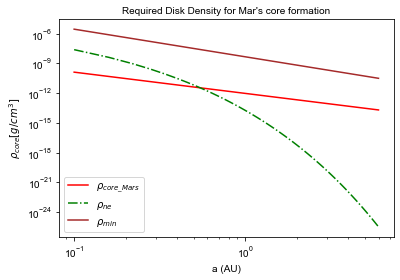

In [9]:
# orbital crossing timescale

M_earth = 5.98*10**27 #[g]

def sig_core(a, M_p):
    Rmh = ((2*M_p)/3/M_sun)**(1/3)*a #in AU
    da = 7.9*Rmh #confirm later
    k = da/Rmh
    h = k/2*((2*M_p)/3/M_sun)**(1/3)
    e = 0.0 #?  

    #check M and Mp
    A = -2 + e/h - 0.27*np.log10((2*M_p)/2/M_sun)
    B = 18.7 - 16.8*e/h + (1.1 - 1.2*e/h)*np.log10((2*M_p)/2/M_sun)
    t_c = 10**(A + B*np.log10(k/2.3))*(a)**1.5 * 3.154*10**7 #[s]
    rho_c = Cs_disk(a)**3/(4*np.pi*G**2*(M_p)*t_c) #disk gas required to form core via giant impact

    K = np.sqrt(G*M_sun/(a*autocm)**3) #[1/s]
    H = Cs_disk(a)/K
    sig_c = rho_c*H
    return sig_c, rho_c, H

sig_c, rho_c, SH = sig_core(a, M_mars/2)
sig_e, rho_e, H_E = sig_core(a, M_earth/2)

rho_mini = rho_c/mini_sig*SH


plt.plot(a, rho_c,'red',label = r'$\rho_{core\_Mars}$')
#plt.plot(a, rho_mini, label = r'$\rho_{core}/\rho_{min}$')
plt.plot(a, rho_ne_sol,'-.', color = 'green',label = r'$\rho_{ne}$')
plt.plot(a,mini_sig/SH,'brown',label = r'$\rho_{min}$')
plt.xscale('log')
plt.yscale('log')
plt.title('Required Disk Density for Mar\'s core formation')
plt.xlabel('a (AU)')
plt.ylabel(r'$\rho_{core}[g/cm^3]$')
plt.legend()
#plt.ylim(10**(-15),10**(-7))
plt.savefig("Rho_core_M150.png",dpi=300, bbox_inches='tight')
plt.show()

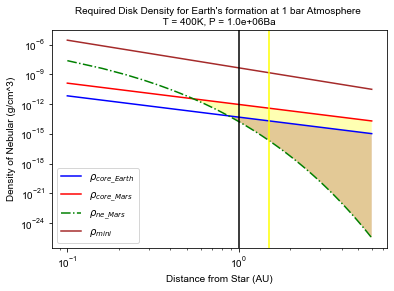

In [10]:
plt.plot(a, rho_e,'blue',label = r'$\rho_{core\_Earth}$')
plt.plot(a, rho_c,'red',label = r'$\rho_{core\_Mars}$')
plt.plot(a, rho_ne_sol,'-.', color = 'green',label = r'$\rho_{ne\_Mars}$')
plt.fill_between(
    a,rho_e,rho_ne_sol,
    where=[(rho_ne_sol[i]<rho_e[i]) for i in range(len(a))],
    facecolor='purple', alpha = 0.3,
    interpolate=True
)
plt.fill_between(
    a,rho_c,rho_ne_sol,
    where=[(rho_ne_sol[i]<rho_c[i]) for i in range(len(a))],
    facecolor='yellow', alpha = 0.3,
    interpolate=True
)
plt.plot(a, mini_sig/SH, 'brown', label = r'$\rho_{mini}$')
plt.xlabel("Distance from Star (AU)")
plt.ylabel("Density of Nebular (g/cm^3)")
plt.xscale('log')
plt.yscale('log')
plt.axvline(x = 1, color = 'black')
plt.axvline(x = 1.5, color = 'yellow')
plt.title(f'Required Disk Density for Earth\'s formation at 1 bar Atmosphere \n T = {T_0}K, P = {P_bot:.1e}Ba ')
plt.legend()
plt.savefig("Rho_Earth_MA_M150.png",dpi=300, bbox_inches='tight')
plt.show()

# minimum for atmosphere
# maximum for core

338000000.0
60.51686980646351
2.878e+01
67468.89170467027


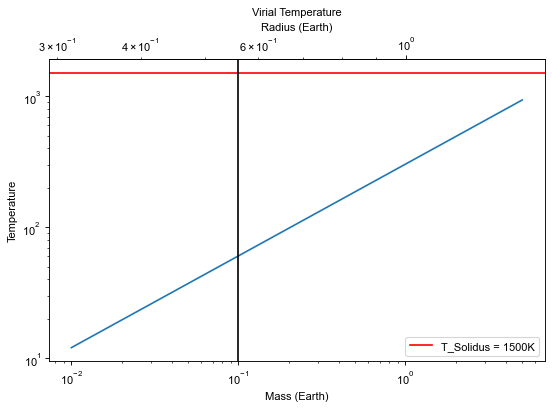

In [94]:
# for R = M^{1/4} relation

def T_virial(M_core):
    R = (3*M_core*M_earth/4/np.pi/8.75/10**(-9))**(0.3) # Earth radius* (Mass_core/Mass_Earth)**1/4
    T = G*(M_core*M_earth)*2.3*m_p/R/k_B
    return T, R

print(R_bot)



M1 = np.linspace(0.01, 5, 1000)
T1, R1 = T_virial(M1)


M2 = 0.1
T2, R2 = T_virial(M2)
print(T2)
print(f'{R2/R_E:.3e}')

print(G*(M_mars)*44*m_p/R_bot/k_B)


fig, ax = plt.subplots(figsize = (8, 5), dpi = 80)

ax.loglog(M1, T1)
ax.set_ylabel('Temperature')
ax.set_xlabel('Mass (Earth)')
ax.set_title('Virial Temperature')

def Radius(M_core):
    R = (3*M_core*M_earth/4/np.pi/8.75/10**(-9))**(1/4)/R_E
    return R

def mass(R):
    M = 4*np.pi*R**4*8.7*10**(-9)/3
    return M

secax = ax.secondary_xaxis('top',functions = (Radius, mass))

secax.set_xlabel("Radius (Earth)")
secax.set_xscale('log')
ax.axhline(y = 1500, c = 'red', label  = 'T_Solidus = 1500K')
ax.axvline(x = 0.1, c = 'black')


ax.legend()
plt.savefig("Solidus_Virial.png",dpi=300, bbox_inches='tight')
plt.show()



# envelope calculation
# not isothermal in the region
# structural equation


637800000.0
3475.147942685963 319657217.6074743
67468.89170467027


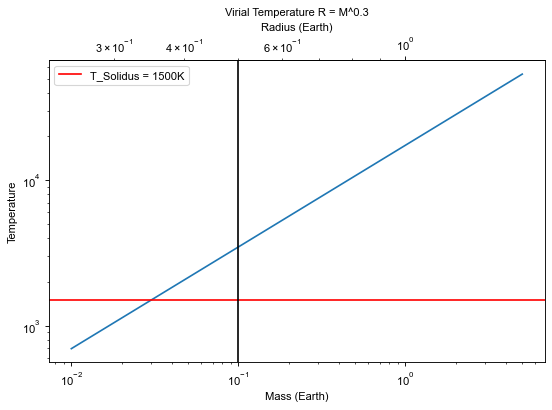

In [5]:
# for R = M^{1/4} relation

def T_virial(M_core):
    R = R_E*(M_core)**(0.3) # Earth radius* (Mass_core/Mass_Earth)**1/4
    T = G*(M_core*M_earth)*2.3*m_p/R/k_B
    return T, R

print(R_E)



M1 = np.linspace(0.01, 5, 1000)
T1, R1 = T_virial(M1)


M2 = 0.1
T2, R2 = T_virial(M2)
print(T2, R2)

print(G*(M_mars)*44*m_p/R_bot/k_B)


fig, ax = plt.subplots(figsize = (8, 5), dpi = 80)

ax.loglog(M1, T1)
ax.set_ylabel('Temperature')
ax.set_xlabel('Mass (Earth)')
ax.set_title('Virial Temperature R = M^0.3')

def Radius(M_core):
    R = (M_core)**(0.3)
    return R

def mass(R):
    M = (R/R_E)**(10/3)
    return M

secax = ax.secondary_xaxis('top',functions = (Radius, mass))

secax.set_xlabel("Radius (Earth)")
secax.set_xscale('log')
ax.axhline(y = 1500, c = 'red', label  = 'T_Solidus = 1500K')
ax.axvline(x = 0.1, c = 'black')


ax.legend()
plt.savefig("Solidus_Virial_0.3.png",dpi=300, bbox_inches='tight')
plt.show()